This notebook will perform analysis of functional connectivity on simulated data.

In [16]:
import os,sys
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
sys.path.insert(0,'../utils')
from mkdesign import create_design_singlecondition
from nipy.modalities.fmri.hemodynamic_models import spm_hrf,compute_regressor
from make_data import make_continuous_data



correlation without activation: -0.633032212608


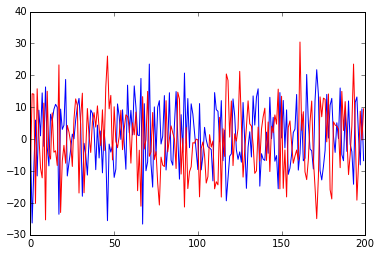

In [17]:
data=make_continuous_data(N=200)
print 'correlation without activation:',numpy.corrcoef(data.T)[0,1]

plt.plot(range(data.shape[0]),data[:,0],color='blue')
plt.plot(range(data.shape[0]),data[:,1],color='red')



Now let's add on an activation signal to both voxels

correlation with activation: 0.775654586286


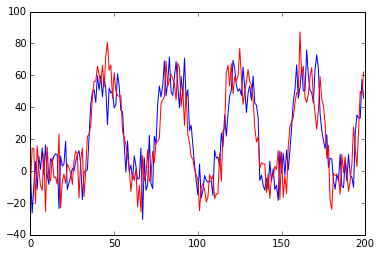

In [18]:
design_ts,design=create_design_singlecondition(blockiness=1.0,offset=30,blocklength=20,deslength=data.shape[0])
regressor,_=compute_regressor(design,'spm',numpy.arange(0,len(design_ts)))

regressor*=50.
data_act=data+numpy.hstack((regressor,regressor))
plt.plot(range(data.shape[0]),data_act[:,0],color='blue')
plt.plot(range(data.shape[0]),data_act[:,1],color='red')
print 'correlation with activation:',numpy.corrcoef(data_act.T)[0,1]


How can we address this problem? A general solution is to first run a general linear model to remove the task effect and then compute the correlation on the residuals.

In [19]:
X=numpy.vstack((regressor.T,numpy.ones(data.shape[0]))).T
beta_hat=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_act)
y_est=X.dot(beta_hat)
resid=data_act - y_est
print 'correlation of residuals:',numpy.corrcoef(resid.T)[0,1]

correlation of residuals: -0.63175452391


What happens if we get the hemodynamic model wrong?  Let's use the temporal derivative model to generate an HRF that is lagged compared to the canonical.

In [20]:
regressor_td,_=compute_regressor(design,'spm_time',numpy.arange(0,len(design_ts)))
regressor_lagged=regressor_td.dot(numpy.array([1,0.5]))*50

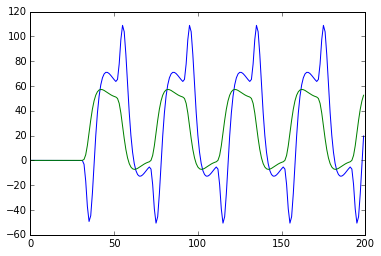

In [21]:
plt.plot(regressor_lagged)
plt.plot(regressor)

correlation of residuals: 0.876508217239


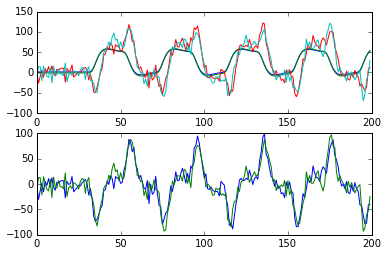

In [22]:
data_lagged=data+numpy.vstack((regressor_lagged,regressor_lagged)).T

beta_hat_lag=numpy.linalg.inv(X.T.dot(X)).dot(X.T).dot(data_lagged)
plt.subplot(211)
y_est_lag=X.dot(beta_hat_lag)
plt.plot(y_est)
plt.plot(data_lagged)
resid=data_lagged - y_est_lag
print 'correlation of residuals:',numpy.corrcoef(resid.T)[0,1]
plt.subplot(212)
plt.plot(resid)

Let's see if using a more flexible basis set, like an FIR model, will allow us to get rid of the task-induced correlation.

In [23]:
regressor_fir,_=compute_regressor(design,'fir',numpy.arange(0,len(design_ts)),fir_delays=range(28))


In [24]:
regressor_fir.shape


(200, 28)

correlation of residuals: -0.641090400808


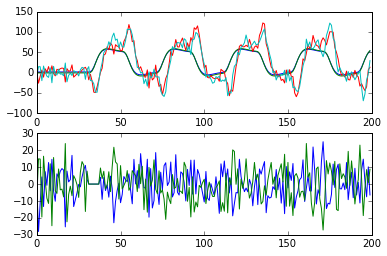

In [25]:
X_fir=numpy.vstack((regressor_fir.T,numpy.ones(data.shape[0]))).T
beta_hat_fir=numpy.linalg.inv(X_fir.T.dot(X_fir)).dot(X_fir.T).dot(data_lagged)
plt.subplot(211)
y_est_fir=X_fir.dot(beta_hat_fir)
plt.plot(y_est)
plt.plot(data_lagged)
resid=data_lagged - y_est_fir
print 'correlation of residuals:',numpy.corrcoef(resid.T)[0,1]
plt.subplot(212)
plt.plot(resid)